In [10]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import numpy as np
import healpy as hp
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import corner
import os

from scipy import optimize
from scipy.stats import poisson

import jax
import jax.numpy as jnp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../utils/matplotlibrc')

from utils import ed_fcts_amarel as ef


[autoreload of __main__ failed: Traceback (most recent call last):
  File "/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/edr76/.conda/envs/jax/lib/python3.11/importlib/__init__.py", line 148, in reload
    raise ImportError(msg.format(name), name=name)
ImportError: module settings_7p1234567_5p23457_1p16_-1_11_291_1001_0 not in sys.modules
]


In [11]:
sim_seeds = np.arange(1000,1010)

outer_radius_list = [30., 32.5, 35., 40., 45., 50., 60., 70.]
svi_seeds = np.arange(len(outer_radius_list))

In [12]:
# load SVI fit results (these should be the only parameters that you are loading)
gpu_id = '1'

# name of the synthetic directory
sim_name = 'canon_g1p2_ola_v2'

# load SVI fit results (these should be the only parameters that you are loading)
sim_id = 7.1234567
temp_id = 5.23457
gp_id = 1.16
blg_id = -1
mod_id = 11
svi_id = 291
sim_seed = 1000
svi_seed = 0

In [13]:
# load GPU
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

data_dir = ef.load_data_dir(sim_name)
os.system("mkdir -p "+data_dir)

# Load the simulated templates
ebin = 10
temp_dict = np.load(data_dir + 'all_templates_ebin' + str(ebin)  + '.npy', allow_pickle=True).item()

In [14]:
fit_filename, module_name = ef.generate_fit_filename_from_ids(sim_id, temp_id, gp_id, blg_id, mod_id, svi_id, sim_seed, svi_seed)
fit_dir = data_dir + 'fits/' + fit_filename + '/'
ef.list_files(fit_dir)

sys.path.append(fit_dir)
import importlib 
module = importlib.import_module(module_name)

# Load all the variables from the module
globals().update(vars(module))

/
    ebin_old_10_smp_svi_0.1_20000_mvn_8_1000_3.p
    ebin10_smp_svi_0.1_20000_mvn_8_1000_2.p
    ebin10_smp_svi_0.1_20000_mvn_8_1000_3.p
    ebin_old_10_smp_svi_0.1_20000_mvn_8_1000_2.p
    settings_7p1234567_5p23457_1p16_-1_11_291_1000_0.py
    ebin_old_10_smp_svi_0.1_20000_mvn_8_1000_0.p
    summary.txt
    ebin10_smp_svi_0.1_20000_mvn_8_1000_1.p
    ebin10_smp_svi_0.1_20000_mvn_8_1000_0.p
    ebin_old_10_smp_svi_0.1_20000_mvn_8_1000_1.p
    __init__.py
    ebin_old_10_smp_svi_0.1_20000_mvn_8_1000_5.p
    ebin10_smp_svi_0.1_20000_mvn_8_1000_4.p
    ebin10_smp_svi_0.1_20000_mvn_8_1000_5.p
    ebin_old_10_smp_svi_0.1_20000_mvn_8_1000_4.p
    ebin_old_10_smp_svi_0.1_20000_mvn_8_1000_6.p
    ebin10_smp_svi_0.1_20000_mvn_8_1000_7.p
    ebin10_smp_svi_0.1_20000_mvn_8_1000_6.p
    ebin_old_10_smp_svi_0.1_20000_mvn_8_1000_7.p
__pycache__/
    settings_7p1234567_5p23457_1p16_-1_11_291_1000_0.cpython-311.pyc


In [15]:
from models.poissonian_gp_roiscan import EbinPoissonModel

ebinmodel = EbinPoissonModel(
        # important parameters
        rig_temp_list = rig_temp_list,
        hyb_temp_list = hyb_temp_list,
        var_temp_list = var_temp_list,
        is_gp = is_gp,
        gp_deriv = gp_deriv,
        data_file = data_file,
        rig_temp_sim = rig_temp_sim,
        hyb_temp_sim = hyb_temp_sim,
        var_temp_sim = var_temp_sim,
        is_custom_blg = is_custom_blg,
        custom_blg_id = custom_blg_id,
        sim_seed = sim_seed,
        Nu = Nu,
        u_option = u_option,
        u_grid_type = u_grid_type,
        u_weights = u_weights,
        Np = Np,
        p_option = p_option,
        Nsub = Nsub,

        # default parameters
        ebin = ebin,
        is_float64 = is_float64,
        debug_nans = debug_nans,
        no_ps_mask = no_ps_mask,
        p_grid_type = p_grid_type,
        p_weights = p_weights,
        gp_kernel = gp_kernel,
        gp_params = gp_params,
        gp_scale_option = gp_scale_option,
        monotonicity_hyperparameter = monotonicity_hyperparameter,
        nfw_gamma = nfw_gamma,
        blg_names = blg_names,
        dif_names = dif_names,
        )
ebinmodel.config_model(ebin=ebin)
mask_p = ebinmodel.mask_roi_arr[ebin]

[autoreload of __mp_main__ failed: Traceback (most recent call last):
  File "/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/edr76/.conda/envs/jax/lib/python3.11/importlib/__init__.py", line 148, in reload
    raise ImportError(msg.format(name), name=name)
ImportError: module settings_7p1234567_5p23457_1p16_-1_11_291_1000_0 not in sys.modules
]


In [16]:
str_svi_seed = str(3)

# load saved data from GP -> Data fit
gp_file_name = ('ebin_old_' + str_ebin + '_smp_svi_' + 
             str_lr + '_' + str_n_steps + '_' + 
                str_guide + '_' + str_num_particles + '_' + 
                str_sim_seed + '_' + str_svi_seed + '.p')

if is_gp:
   samples, svi_results, gp_samples = pickle.load(open(fit_dir + gp_file_name, 'rb'))
else:
   samples, svi_results = pickle.load(open(fit_dir + gp_file_name, 'rb'))

In [17]:
def truncate_samples(samples, n_samples):
    for key in samples.keys():
        samples[key] = samples[key][:n_samples]
    return samples

In [18]:
# TODO: Probably a better way to collect this data; 
# for example, make a dictionary whose inputs are ordered pairs of the variable inputs

svi_results_list = []
samples_list = []
gp_samples_list = []
temp_sample_dict_list = []

q_list = []

temp_names_sim = rig_temp_sim + hyb_temp_sim + var_temp_sim # imported from settings file

for _svi_seed in tqdm(svi_seeds, desc = 'svi_seeds'):
   aug_samples = []
   aug_gp_samples = []

   for sim_seed in tqdm(sim_seeds, desc = 'mod_ids'):
      # if fit_dir in sys.path:
      #     sys.path.pop(-1)
      svi_seed_load = 0
      fit_filename, module_name = ef.generate_fit_filename_from_ids(sim_id, temp_id, gp_id, blg_id, mod_id, svi_id, sim_seed, svi_seed_load)
      fit_dir = data_dir + 'fits/' + fit_filename + '/'

      sys.path.append(fit_dir)
      import importlib 
      module = importlib.import_module(module_name)

      # Load all the variables from the module
      globals().update(vars(module))

      svi_seed = _svi_seed
      str_svi_seed = str(_svi_seed)
      file_name = ('ebin_old_' + str_ebin + '_smp_svi_' + 
                  str_lr + '_' + str_n_steps + '_' + 
                     str_guide + '_' + str_num_particles + '_' + 
                     str_sim_seed + '_' + str_svi_seed + '.p')

      if is_gp:
         samples, svi_results, gp_samples = pickle.load(open(fit_dir + file_name, 'rb'))
      else:
         samples, svi_results = pickle.load(open(fit_dir + file_name, 'rb'))
      
      samples = truncate_samples(samples,1000)
      gp_samples = gp_samples

      if len(aug_samples) == 0:
         aug_samples = samples
      else:
         for key in samples.keys():
            aug_samples[key] = np.concatenate((aug_samples[key], samples[key]))

      if len(aug_gp_samples) == 0:
         aug_gp_samples = gp_samples
      else:
         aug_gp_samples = np.concatenate((aug_gp_samples, gp_samples), axis = 0)
      
   samples = aug_samples
   gp_samples = aug_gp_samples
   temp_sample_dict = ef.generate_temp_sample_maps(samples, ebinmodel, gp_samples = gp_samples, custom_mask = mask_p, custom_num=1000, nfw_gamma=nfw_gamma)

   norm_sum = {}
   for name in list(temp_sample_dict.keys()):
      if name == 'gp':
            true_sum = temp_dict['nfw'][~mask_p].sum() + temp_dict['blg'][~mask_p].sum()
            norm_sum[name] = (temp_sample_dict[name].sum(axis=1) - true_sum) / true_sum
      else:
            true_sum = temp_dict[name][~mask_p].sum()
            norm_sum[name] = (temp_sample_dict[name].sum(axis=1) - true_sum) / true_sum

   q_dict = {}
   for name in list(norm_sum.keys()):
      q_dict[name] = np.quantile(norm_sum[name], [0.16, 0.5, 0.84], axis=0)

   q_list.append(q_dict)

print('DONE')

mod_ids: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


iso
psc
bub
pib


100%|██████████| 1000/1000 [00:01<00:00, 559.81it/s]


ics


mod_ids: 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


iso
psc
bub
pib


100%|██████████| 1000/1000 [00:01<00:00, 580.96it/s]


ics


mod_ids: 100%|██████████| 10/10 [00:02<00:00,  4.60it/s]


iso
psc
bub
pib


100%|██████████| 1000/1000 [00:01<00:00, 604.68it/s]


ics


mod_ids: 100%|██████████| 10/10 [00:01<00:00,  5.11it/s]


iso
psc
bub
pib


100%|██████████| 1000/1000 [00:01<00:00, 595.18it/s]


ics


mod_ids: 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]


iso
psc
bub
pib


100%|██████████| 1000/1000 [00:01<00:00, 622.29it/s]


ics


mod_ids: 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]


iso
psc
bub
pib


100%|██████████| 1000/1000 [00:01<00:00, 574.36it/s]


ics


mod_ids: 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


iso
psc
bub
pib


100%|██████████| 1000/1000 [00:01<00:00, 576.32it/s]


ics


mod_ids: 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


iso
psc
bub
pib


100%|██████████| 1000/1000 [00:01<00:00, 587.27it/s]


ics


svi_seeds: 100%|██████████| 8/8 [00:48<00:00,  6.07s/it]

DONE


In [19]:
q_dict = {}
for name in norm_sum.keys():
    q_dict[name] = np.array([q_list[i][name] for i in range(len(q_list))]).T

[autoreload of __main__ failed: Traceback (most recent call last):
  File "/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/edr76/.conda/envs/jax/lib/python3.11/importlib/__init__.py", line 148, in reload
    raise ImportError(msg.format(name), name=name)
ImportError: module settings_7p1234567_5p23457_1p16_-1_11_291_1009_0 not in sys.modules
]
[autoreload of __main__ failed: Traceback (most recent call last):
  File "/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 471, in superrel

In [20]:
q_dict['gp'].shape

(3, 8)

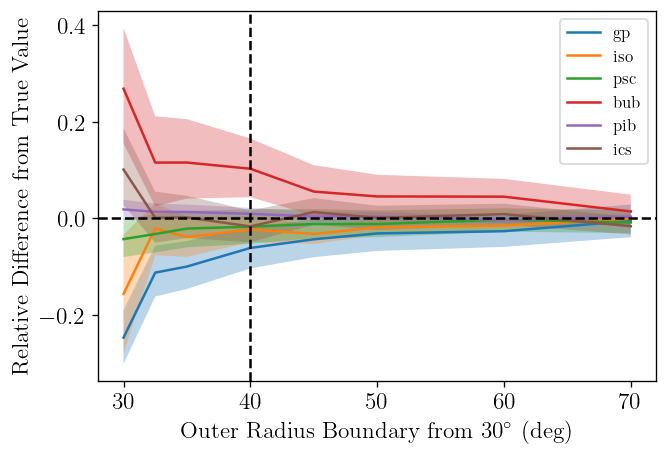

In [21]:
for name in list(norm_sum.keys()):
    plt.plot(outer_radius_list, q_dict[name][1], label=name)
    plt.fill_between(outer_radius_list, q_dict[name][0], q_dict[name][2], alpha=0.3)
plt.legend(fontsize = 10)
plt.xlabel('Outer Radius Boundary from $30^{\circ}$ (deg)')
plt.ylabel('Relative Difference from True Value')
plt.axvline(x = 40, color = 'black', linestyle = '--')
plt.axhline(y = 0, color = 'black', linestyle = '--')

In [22]:
pickle.dump(
    (outer_radius_list, q_dict),
    open('../figures/data/appdata_roi_outer_radius_scan.p', 'wb')
)

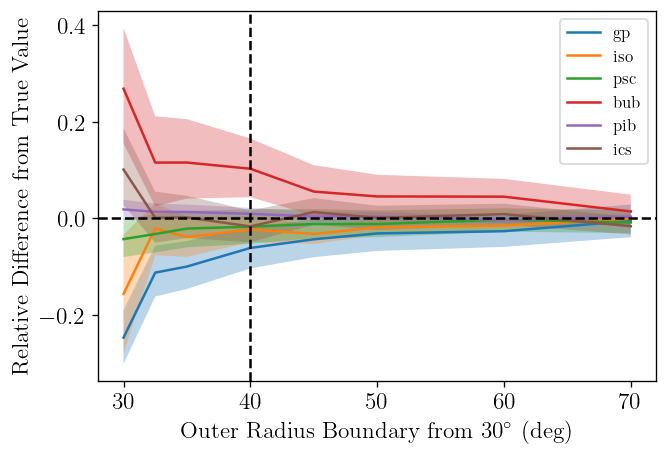

In [23]:
for name in list(norm_sum.keys()):
    plt.plot(outer_radius_list, q_dict[name][1], label=name)
    plt.fill_between(outer_radius_list, q_dict[name][0], q_dict[name][2], alpha=0.3)
plt.legend(fontsize = 10)
plt.xlabel('Outer Radius Boundary from $30^{\circ}$ (deg)')
plt.ylabel('Relative Difference from True Value')
plt.axvline(x = 40, color = 'black', linestyle = '--')
plt.axhline(y = 0, color = 'black', linestyle = '--')

In [24]:
Nr = len(sim_seeds)
for nr in tqdm(range(Nr), desc = 'sim_seeds'):
    samples = samples_sim[nr]
    plt.hist(np.log10(samples['S_ics']), color = 'k', alpha = 0.1)
    plt.axvline(np.log10(temp_dict['S_ics']), color = 'k')

sim_seeds:   0%|          | 0/10 [00:00<?, ?it/s]

NameError: name 'samples_sim' is not defined

In [ ]:


# NOTE: Indices now don't track the IDs. So, you need to keep track of the indices
# Ns = len(svi_ids)
# Nr = len(sim_seeds)
for nr in tqdm(range(Nr), desc = 'sim_seeds'):
    samples = samples_sim[nr]
    gp_samples = gp_samples_sim[nr]
    temp_sample_dict = ef.generate_temp_sample_maps(samples, ebinmodel, gp_samples = gp_samples, custom_num=None, nfw_gamma=nfw_gamma)
    temp_sample_dict_sim.append(temp_sample_dict)

sim_seeds:   0%|          | 0/7 [00:00<?, ?it/s]

iso
psc
bub
pib


100%|██████████| 1000/1000 [00:02<00:00, 340.38it/s]


ics


sim_seeds:  14%|█▍        | 1/7 [00:06<00:37,  6.33s/it]

iso
psc
bub
pib


100%|██████████| 1000/1000 [00:02<00:00, 366.34it/s]


ics


sim_seeds:  29%|██▊       | 2/7 [00:11<00:29,  5.90s/it]

iso
psc
bub
pib


100%|██████████| 1000/1000 [00:02<00:00, 356.01it/s]


ics


sim_seeds:  43%|████▎     | 3/7 [00:17<00:23,  5.82s/it]

iso
psc
bub
pib


100%|██████████| 1000/1000 [00:02<00:00, 339.48it/s]


ics


sim_seeds:  57%|█████▋    | 4/7 [00:23<00:17,  5.95s/it]

iso
psc
bub
pib


100%|██████████| 1000/1000 [00:02<00:00, 369.40it/s]


ics


sim_seeds:  71%|███████▏  | 5/7 [00:29<00:11,  5.85s/it]

iso
psc
bub
pib


100%|██████████| 1000/1000 [00:02<00:00, 374.50it/s]


ics


sim_seeds:  86%|████████▌ | 6/7 [00:35<00:05,  5.89s/it]

iso
psc
bub
pib


100%|██████████| 1000/1000 [00:02<00:00, 370.63it/s]


ics


sim_seeds: 100%|██████████| 7/7 [00:41<00:00,  5.88s/it]


sim_seeds:   0%|          | 0/7 [00:00<?, ?it/s]

sim_seeds: 100%|██████████| 7/7 [00:00<00:00,  8.08it/s]


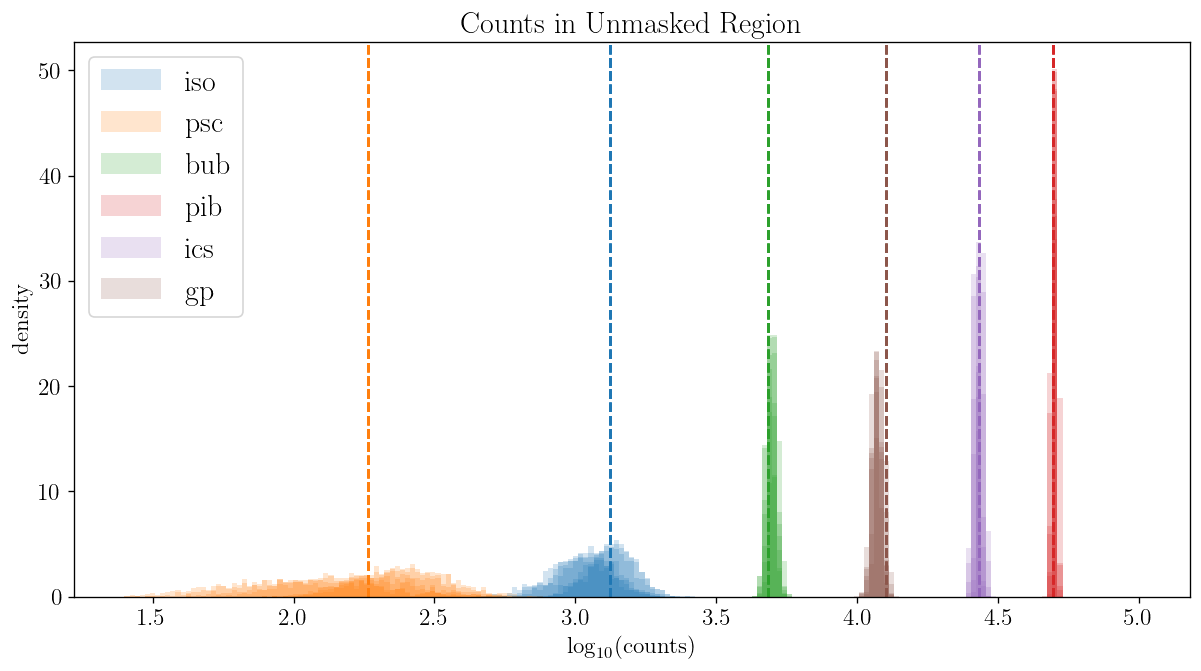

In [ ]:
fig = plt.figure(figsize=(12, 6), dpi= 120)
ax = fig.add_subplot(111)

bins = np.linspace(1.4,5.,200)
alpha = 0.2
histtype = 'stepfilled'

all_temp_names = ['iso', 'psc', 'bub', 'pib', 'ics', 'blg', 'gp', 'nfw', 'dsk']
ccodes = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C5', 'C6', 'C7']
names = list(temp_sample_dict.keys())
ordered_names = [name for name in all_temp_names if name in names]

# Ns = len(svi_ids)
# Nr = len(sim_seeds)
c = 0
for nr in tqdm(range(Nr), desc = 'sim_seeds'):
    temp_sample_dict = temp_sample_dict_sim[nr]
    for k in range(len(ordered_names)):
        name = ordered_names[k]
        idx = all_temp_names.index(name)
        ccode = ccodes[idx]
        # if name == 'gp':
        #     temp_sum = jnp.exp(temp_sample_dict[name]).sum(axis = 1) # sum over spatial bins
        #     ax.hist(np.log10(temp_sum), bins = bins, alpha = 0.75, label = name, density = True, histtype = 'step', color = ccode)
        # else:
        temp_sum = temp_sample_dict[name].sum(axis = 1) # sum over spatial bins
        if c == 0:
            ax.hist(np.log10(temp_sum), bins = bins, alpha = alpha, label = name, density = True, histtype = histtype, color = ccode)
        else:
            ax.hist(np.log10(temp_sum), bins = bins, alpha = alpha, density = True, histtype = histtype, color = ccode)

    if temp_dict is not None:
        names_sim = temp_names_sim # this piece is provided by the "settings" file since we only save a dictionary with all the fit parameters
        ordered_names_sim = [name for name in all_temp_names if name in names_sim]
        for k in range(len(ordered_names_sim)):
            name = ordered_names_sim[k]
            idx = all_temp_names.index(name)
            ccode = ccodes[idx]
            if ordered_names_sim[k] == 'nfw':
                continue
            elif ordered_names_sim[k] == 'blg':
                temp_sum_sim = temp_dict['blg'].sum(axis = 0) + temp_dict['nfw'].sum(axis = 0) 
                ax.axvline(np.log10(temp_sum_sim), linestyle='--', c = ccode)
            else:
                temp_sum_sim = temp_dict[name].sum(axis = 0)
                ax.axvline(np.log10(temp_sum_sim), linestyle='--', c = ccode)
    c += 1
    
    ax.legend()
    ax.set_xlabel(r'$\log_{10}(\mathrm{counts})$')
    ax.set_ylabel(r'$\mathrm{density}$')
    ax.set_title(r'$\mathrm{Counts\ in\ Unmasked\ Region}$')